In [1]:
import h5py as h5
from math import sqrt,pi
import numpy as np
import matplotlib.pyplot as plt
from plot_settings import plotparams
from kinematic_functions import zed#qsq,k,wl
from BGL import phi#,blaschke
#from scipy.optimize import minimize_scalar
import time
import masses
from tqdm import tqdm
from numba import jit
from multiprocessing import Pool
import os

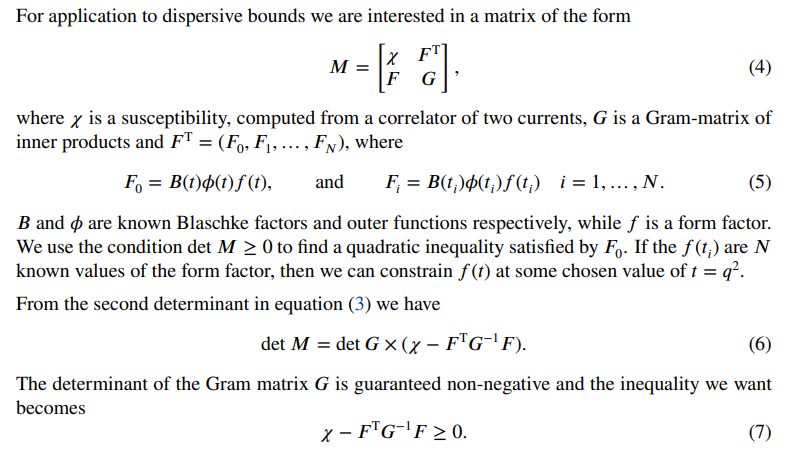

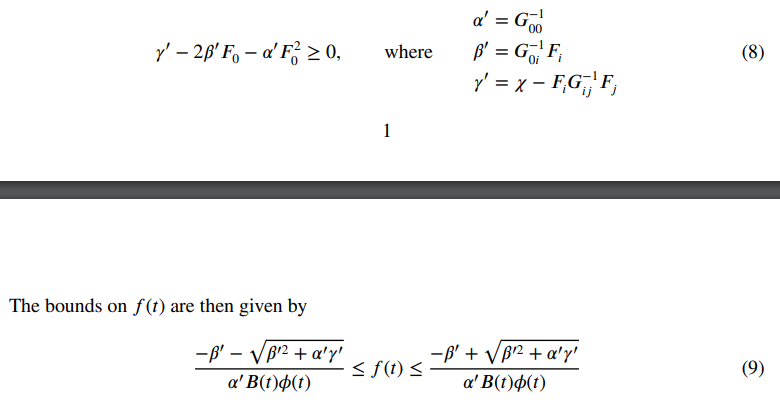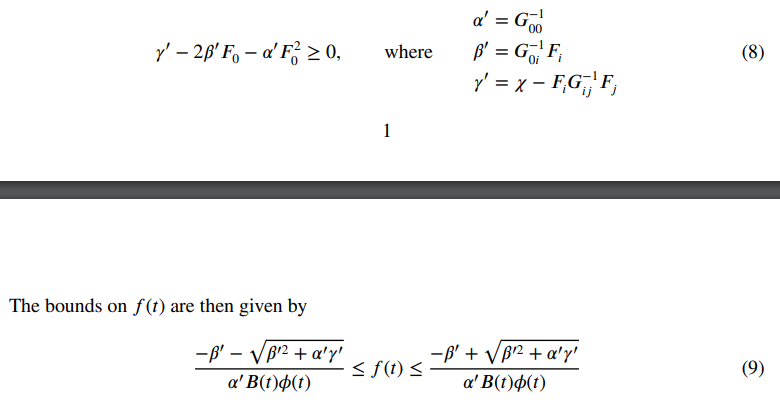

In [2]:
#plt.rcParams.update(plotparams)

In [3]:
c = 0.1
angular_momentum_constraint = False

In [4]:
# light mesons
mpi=(2*0.13957061+0.1349770)/3 # PDG2018
mK=(0.493677+0.497611)/2       # PDG2018

# B mesons
mB=(5.27933+5.27964)/2
mBstar= 5.32470
mBs=5.36682
mBstar0plus=5.63

tp=(mBs+mK)**2
tm=(mBs-mK)**2 # = qsqmax
tcut=(mB+mpi)**2
t0=tcut-sqrt(tcut*(tcut-tm))# D mesons

etaBsK=1
chi1minusBsK=6.03e-4
chi0plusBsK=1.48e-2
fpluspoles=np.array([mBstar])
fzeropoles=np.array([])

zmax=zed(0,tcut,t0)

# z-values for pole positions
zpluspole=zed(mBstar**2,tcut,t0)
#zzeropole=zed(mBstar0plus**2,tcut,t0) # mBstar0plus is above threshold
#nplus=2 # number of input values for f+
#nzero=3 # number of input values for f0
#qsqmin='17.50' # (17.50,18.,00,18.50,19.00)
path=''


In [5]:
print(tcut,t0)

29.349570696829012 16.505106939547048


In [6]:
#@jit(nopython=True)
def z(t):
    return zed(t,tcut,t0)

In [7]:
z(0)

0.20370148194672394

In [8]:
#@jit(nopython=True)
def gt(z):
    return (1-z**2)**-1

In [9]:
#@jit(nopython=True)
def g0_function(z_in):
    return 1/(1-z(0)*z_in)

In [10]:
def g0t(z):
    return np.array([gt(z),0])

In [11]:
def gpt(z):
    return np.array([0,gt(z)])

In [12]:
def g0z(z_in):
    element = g0_function(z_in)
    return np.array([element,element])

In [13]:
def f(t_in,c = 0.1):
    z_in = z(t_in)
    zpin=z_in
    zzin=z_in
    
    phiFp=phi(t_in,3,2,tcut,t0,tm,(etaBsK,48.0*pi,1.0))*((zpin-zppole)/(1.0-zpin*zppole))*fpin
    phiFz=phi(t_in,1,1,tcut,t0,tm,(etaBsK,16.0*pi/(tp*tm),1.0))*fzin
    return np.array([(1-c)*phiFz],c*phiFp)

In [14]:
@jit(nopython=True)
def ggzprod(zi,zj):
    """
    inner product <g_s|g_t>
    """
    return 1.0/(1.0-zi*zj)

In [15]:
#@jit(nopython=True)
def Gmatrix(tzinlist,tpinlist,c = 0.1):
    q2val = 0
    """
    G matrix for values of z in list zl
    """
    Gmatlen = len(tzinlist) + len(tpinlist) + 1
    tinlist = np.append(tzinlist,tpinlist)
        
    G=np.zeros((Gmatlen,Gmatlen))
    nz = len(tzinlist)
    for i in range(len(tzinlist)):
        tzin = tzinlist[i]
        G[i+1,i+1]= ggzprod(z(tzin),z(tzin))
        for j in range(i+1,len(tzinlist)):
            tzin2 = tzinlist[j]
            G[i+1,j+1]= ggzprod(z(tzin),z(tzin2))#gt(z(tzin))*gt(z(tzin2))
            G[j+1,i+1]=G[i+1,j+1]
    #print("nz = ",nz)
    for i,tpin in enumerate(tpinlist):
        G[nz+i+1,nz+i+1]= ggzprod(z(tpin),z(tpin))
        for j in range(i+1,len(tpinlist)):
            tpin2 = tpinlist[j]
            G[nz+1+i,nz+1+j]= ggzprod(z(tpin),z(tpin2))#gt(z(tzin))*gt(z(tzin2))
            G[nz+1+j,nz+1+i]= G[nz+1+i,nz+1+j]
    
    
        
    G[0,0] = g0_function(z(0))*((1-c)**2+c**2)
    
    for i,tzin in enumerate(tzinlist):
        G[0,i+1] = ggzprod(z(tzin),z(0))*(1-c)
        G[i+1,0] = G[0,i+1]
    for j,tpin in enumerate(tpinlist):
        G[0,nz+j+1] = ggzprod(z(tpin),z(0))*(c)
        G[nz+j+1,0] = G[0,nz+j+1]
    #print("detG", np.linalg.det(G))
    #print("G = ",G)
    return G

In [16]:
@jit(nopython=True)
def Old_Gmatrix(zl):
    """
    G matrix for values of z in list zl
    """
    npts=len(zl)
    G=np.zeros((npts,npts))
    for i,zi in enumerate(zl):
        G[i,i]=ggzprod(zi,zi)
        for j in range(i+1,npts):
            G[i,j]=ggzprod(zi,zl[j])
            G[j,i]=G[i,j]
    return G

In [17]:
def kin_bounds_old(fpinputs,fzinputs):
    tpin,fpin,chip,zppole=fpinputs
    tzin,fzin,chiz,zzpole=fzinputs
    zpin=[zed(t,tcut,t0) for t in tpin]
    zzin=[zed(t,tcut,t0) for t in tzin]
    #print(np.shape(tpin),np.shape(zpin),np.shape(fpin),chip,zppole)
    tlist = tzin + tpin
    phiFp=[phi(t,3,2,tcut,t0,tm,(etaBsK,48.0*pi,1.0))*((zpin[i]-zppole)/(1.0-zpin[i]*zppole))*fpin[i]/phi(0,3,2,tcut,t0,tm,(etaBsK,48.0*pi,1.0))*((z(0)-zppole)/(1.0-z(0)*zppole)) for i,t in enumerate(tpin)]
    phiFz=[phi(t,1,1,tcut,t0,tm,(etaBsK,16.0*pi/(tp*tm),1.0))*fzin[i]/phi(0,1,1,tcut,t0,tm,(etaBsK,16.0*pi/(tp*tm),1.0)) for i,t in enumerate(tzin)]
    kinG = Gmatrix(tzin,tpin)
    #print(np.shape(phiFp),np.shape(fpinputs))
    invG = np.linalg.inv(kinG)
    Fvector = np.append([gt(z(t))*(1-c)*phiFz[i] for i,t in enumerate(tzin)],[gt(z(t))*c*phiFp[i] for i,t in enumerate(tpin)])
    
    
    
    mixedchi = (1-c)**2*chi0plusBsK/(phi(0,1,1,tcut,t0,tm,(etaBsK,16.0*pi/(tp*tm),1.0)))**2 + c**2*chi1minusBsK/(phi(0,3,2,tcut,t0,tm,(etaBsK,48.0*pi,1.0))*((z(0)-zppole)/(1.0-z(0)*zppole)))**2
#     if mixedchi-np.dot(Fvector,np.dot(invG,Fvector)) < 0:
#         return np.array([0,0])
    print(invG)
    alpha = invG[0,0]
    print("alpha = ",alpha)
    beta = 0
    for i in range(np.shape(invG)[0]-1):
        beta += invG[0,i+1]*Fvector[i]
    
    print("beta = ",beta)
    gamma = mixedchi
    for i in range(np.shape(invG)[0]-1):
        for j in range(np.shape(invG)[0]-1):
            gamma += -Fvector[i]*invG[i,j]*Fvector[j]
    
    print("gamma = ",gamma)
    print("Fvector = ", Fvector)
    discrim = (beta**2 + alpha*gamma)**0.5/(alpha)
    print(discrim)
    if discrim < 0:
        discrim = 0
    
#     for i in enumerate(fzinputts):
#         np.append(gt(z))
    
    
#     boundsl=np.zeros((len(tl),4))
    centralval = -beta/(alpha)
    return np.array([centralval,discrim])

In [18]:
def phiplus(t):
    return phi(t,3,2,tcut,t0,tm,(etaBsK,48.0*pi,1.0))*((z(t)-zpluspole)/(1.0-z(t)*zpluspole))

In [19]:
def phizero(t):
    return phi(t,1,1,tcut,t0,tm,(etaBsK,16.0*pi/(tp*tm),1.0))

In [20]:
def kin_bounds(fpinputs,fzinputs,c = 0.1):
    tpin,fpin,chip,zppole=fpinputs
    tzin,fzin,chiz,zzpole=fzinputs
    #print(fpin,fzin)

    #tlist = tzin + tpin
    phiFp=[phiplus(t)*fpin[i]/phiplus(0) for i,t in enumerate(tpin)]
    phiFz=[phizero(t)*fzin[i]/phizero(0) for i,t in enumerate(tzin)]
    
    Fvector = [(1-c)*phiFz[i] for i,t in enumerate(tzin)] + [c*phiFp[i] for i,t in enumerate(tpin)]
    kinG = Gmatrix(tzin,tpin)
    D,U = Gdiag(kinG)

    mixedchi = (1-c)**2*chiz/phizero(0)**2 + c**2*chip/phiplus(0)**2
    #print("mixedchi = ",mixedchi)
    fhat = [np.sum([U[i,j+1]*Fvector[j] for j in range(np.shape(U)[0]-1)]) for i in range(np.shape(U)[0])]
    #print(fhat)
    alpha = np.sum([U[i,0]**2/D[i,i] for i in range(np.shape(U)[0])])
    beta = np.sum([U[i,0]*fhat[i]/D[i,i] for i in range(np.shape(U)[0])])
    gamma = mixedchi - np.sum([(fhat[i]**2)/D[i,i] for i in range(np.shape(U)[0])])
    ssum = []
    for i in range(0,len(fhat)):
        for j in range(i+1,len(fhat)):
            ssum.append((2.0*U[i,0]*U[j,0]*fhat[i]*fhat[j]-U[i,0]**2*fhat[j]**2-U[j,0]**2*fhat[i]**2)/(D[i,i]*D[j,j]))
            
        
    ssum.append(alpha*mixedchi)
    summand = sort_list(ssum)
    discrim = 0.0
    for i in range(len(ssum)):
        discrim += summand[i]

    if abs(discrim/summand[0]) < 10**-10:
        discrim = 0.0
    #if discrim < 0:
    #print("discriminant = ",discrim,np.sqrt(discrim)/(alpha))
    
    lowerbound = (-beta-np.sqrt(discrim))/(alpha*((1-c)**2+c**2))#*(phizero(0)/phizero(10))
    upperbound = (-beta+np.sqrt(discrim))/(alpha*((1-c)**2+c**2))#*(phizero(0)/phizero(10))
    altdiscrim = beta**2 +alpha*gamma
    if altdiscrim <0:
        print("altdiscrim <0")
    #print([lowerbound,upperbound])#,[(-beta-np.sqrt(altdiscrim))/(alpha),(-beta+np.sqrt(altdiscrim))/(alpha)])
    return np.array([lowerbound,upperbound])

In [21]:
def Gdiag(G):
    #print(G)
    tempresult = np.linalg.svd(G)
    D = np.diag(tempresult[1])
    U = np.transpose(np.array(tempresult[0]))
    return D,U

In [22]:
def sort_list(numlist):
    return np.flip(sorted(numlist, key = abs))

In [23]:
def compute_bounds(tl,fpinputs,fzinputs):
    """Compute dispersive bounds at a list of t = qsq values given input
        data on f+ and f0
        tl : one or a list of t values
        fpinputs = (tinl,fl,chi)
            tinl : t-values where form factor f+ is known
            fl : corresponind f+ form factor values
            chi : chi for f+
            zpole : pole location for f+
        fzinputs = (zl,fl,chi)
            zl : z-values where form factor f0 is known
            fl : corresponind f0 form factor values
            chi : chi for f0
            zpole : pole location for f0

        returns 1D array fp,dfp,fz,dfz if tl is a single value
        returns array of shape (nt,4) if tl has nt values
        returns np.array([0,0,0,0]) if unitarity check on inputs fails
    """
    tpin,fpin,chip,zppole=fpinputs
    tzin,fzin,chiz,zzpole=fzinputs
    zpin=zed(tpin,tcut,t0)
    zzin=zed(tzin,tcut,t0)

    #phifp=phi(tin,3,2,tcut,t0,tm,(eta,48.0*pi,1.0))*blaschke(tin,tcut,fpluspoles)*fpin
    #phifz=phi(tin,1,1,tcut,t0,tm,(eta,16.0*pi/(tp*tm),1.0))*blaschke(tin,tcut,fzeropoles)*fzin
    # if only one pole for each form factor, calculate Blaschke factors more directly
    Fp=phi(tpin,3,2,tcut,t0,tm,(etaBsK,48.0*pi,1.0))*((zpin-zppole)/(1.0-zpin*zppole))*fpin
    #Fz=phi(tzin,1,1,tcut,t0,tm,(eta,16.0*pi/(tp*tm),1.0))*((zzin-zzpole)/(1.0-zzin*zzpole))*fzin
    Fz=phi(tzin,1,1,tcut,t0,tm,(etaBsK,16.0*pi/(tp*tm),1.0))*fzin

    dil=[np.prod((1.0-z*np.delete(zpin,i))/(z-np.delete(zpin,i))) for i,z in enumerate(zpin)]
    Fpdl=Fp*dil*(1.0-zpin**2)
    Gp=Old_Gmatrix(zpin)
    chimchibarp=chip-np.dot(Fpdl,np.dot(Gp,Fpdl)) # should be positive
    if chimchibarp<0.0:
        #print('unitarity failed for f+ inputs: ',chimchibarp)
        return np.array([0,0,0,0])

    dil=[np.prod((1.0-z*np.delete(zzin,i))/(z-np.delete(zzin,i))) for i,z in enumerate(zzin)]
    Fzdl=Fz*dil*(1.0-zzin**2)
    Gz=Old_Gmatrix(zzin)
    chimchibarz=chiz-np.dot(Fzdl,np.dot(Gz,Fzdl)) # should be positive
    if chimchibarz<0.0:
        #print('unitarity failed for f0 inputs: ',chimchibarz)
        return np.array([0,0,0,0])

    # start t- and z0-dependent stuff
    if type(tl)==float:
        tl=[tl]
    boundsl=np.zeros((len(tl),4))
    for i,t in enumerate(tl):
        z0=zed(t,tcut,t0)

        jot=1.0e-6
        dtl=np.abs(t-tpin)
        if np.min(dtl)<jot: # numerically avoid problems it t is one of the input t-values
            fp,dfp=fpin[np.argmin(dtl)],0.0
        else:
            d0=np.prod((1.0-z0*zpin)/(z0-zpin))
            phipt=phi(t,3,2,tcut,t0,tm,(etaBsK,48.0*pi,1.0))*((z0-zppole)/(1.0-z0*zppole))
            fp,dfp=(-np.dot(Fpdl,1.0/(zpin-z0))/d0,
                    sqrt(chimchibarp/(1-z0*z0))/abs(d0))/phipt

        dtl=np.abs(t-tzin)
        if np.min(dtl)<jot:
            fz,dfz=fzin[np.argmin(dtl)],0.0
        else:
            d0=np.prod((1.0-z0*zzin)/(z0-zzin))
            #phizt=phi(t,1,1,tcut,t0,tm,(eta,16.0*pi/(tp*tm),1.0))*((z0-zzpole)/(1.0-z0*zzpole))
            phizt=phi(t,1,1,tcut,t0,tm,(etaBsK,16.0*pi/(tp*tm),1.0))
            fz,dfz=(-np.dot(Fzdl,1.0/(zzin-z0))/d0,
                    sqrt(chimchibarz/(1-z0*z0))/abs(d0))/phizt

        boundsl[i]=fp,dfp,fz,dfz

    if boundsl.shape==(1,4):
        return boundsl[0]
    else:
        return boundsl

In [24]:
def ff_E(Evec,pole,coeff):
  # construct ff from HMChPT in continuum limit
  return [1./(E+pole)*np.sum([E**i*coeff[i] for i in range(len(coeff))]) for E in Evec]

In [25]:
def cov_ff_p0(Evec_p,Evec_0,C,Np,N0,pole_p,pole_0):
  # construct covariance matrix for ff from HMChPT in continuum limit
  Y_E_p_vec   	= lambda E_p: np.r_[ np.array([1./(E_p+pole_p)*E_p**i for i in range(Np)])]
  Y_E_0_vec   	= lambda E_0: np.r_[ np.array([1./(E_0+pole_0)*E_0**i for i in range(N0)])]
  Cpp		= np.array([[np.dot(Y_E_p_vec(E1),np.dot(C[:Np,:Np],Y_E_p_vec(E2)))
					for E1 in Evec_p] for E2 in Evec_p])
  C00		= np.array([[np.dot(Y_E_0_vec(E1),np.dot(C[Np:,Np:],Y_E_0_vec(E2)))
					for E1 in Evec_0] for E2 in Evec_0])
  Cp0		= np.array([[np.dot(Y_E_p_vec(E1),np.dot(C[:Np:,Np:],Y_E_0_vec(E2)))
					for E1 in Evec_p] for E2 in Evec_0])
  M0		= np.r_['-1',Cpp  ,Cp0.T]
  M1		= np.r_['-1',Cp0  ,C00  ]
  M		= np.r_[M0,M1]
  return M

In [26]:
# define kinematics
mKphys		= masses.mK
mBsphys		= masses.mBs

In [27]:
def bounds_from_input_q2(plustlist,zerotlist,nboot=2000,toutl=np.linspace(0.0,tm,10)):
    nplus = len(plustlist)
    nzero = len(zerotlist)
    #
    qsq_refK_plus	= np.array(plustlist)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))
    qsq_refK_zero	= np.array(zerotlist)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))

    #
    ksq_refK_plus 	= (mBsphys**4+(mKphys**2-qsq_refK_plus)**2-2*mBsphys**2*(mKphys**2+qsq_refK_plus))/(4*mBsphys**2)
    ksq_refK_zero 	= (mBsphys**4+(mKphys**2-qsq_refK_zero)**2-2*mBsphys**2*(mKphys**2+qsq_refK_zero))/(4*mBsphys**2)

    ErefK_plus 	 	= np.sqrt(mKphys**2+ksq_refK_plus)
    ErefK_zero 	 	= np.sqrt(mKphys**2+ksq_refK_zero)
    Deltapar	= + 0.263
    Deltaperp	= - 0.0416


    f=h5.File('BstoK_ref_ff_dat.hdf5','r')
    cp_BstoK=np.array(f.get('cp'))
    c0_BstoK=np.array(f.get('c0'))
    Cp0_BstoK=np.array(f.get('Cp0'))
    fp_BstoK 	= np.array(ff_E(ErefK_plus,Deltaperp,cp_BstoK))
    f0_BstoK 	= np.array(ff_E(ErefK_zero,Deltapar ,c0_BstoK))
    ff_ref		= np.r_[ fp_BstoK, f0_BstoK]
    Cp0_ref 	= cov_ff_p0(ErefK_plus,ErefK_zero,Cp0_BstoK,2,3,Deltaperp,Deltapar)

    bskpts = np.r_[fp_BstoK,f0_BstoK]
    bskcov = np.array(Cp0_ref)

    qsqinputl = np.array(plustlist + zerotlist)


    zinputl=zed(qsqinputl,tcut,t0)

    npts=len(bskpts)
    bskptslbls=[char for char in nplus*'+'+nzero*'0']

    dbsk=np.sqrt(bskcov.diagonal())
    bskcov=0.5*(bskcov + np.transpose(bskcov))

    # input f+ and f0 values
    tpin=qsqinputl[:nplus]
    zpin=zed(tpin,tcut,t0)
    fpin=bskpts[:nplus]
    dfpin=dbsk[:nplus]
    tzin=qsqinputl[nplus:]
    zzin=zed(tzin,tcut,t0)
    fzin=bskpts[nplus:]
    dfzin=dbsk[nplus:]
    nppts=len(zpin)
    nzpts=len(zzin)

    # print('Inputs: first for f+ then f0')
    # with np.printoptions(precision=4,floatmode='fixed',
    #                       formatter={'float_kind':lambda x: '{:6.4f}'.format(x)}):
    #     print('t=q^2',tpin,tzin)
    #     print('z(t) ',zpin,zzin)
    #     print('f+/0 ',fpin,fzin)
    #     print('df+/0',dfpin,dfzin)
    # print('')




    fpinputs=(tpin,fpin,chi1minusBsK,zpluspole)
    fzinputs=(tzin,fzin,chi0plusBsK,zpluspole) # !!! zpluspole just a dummy here
    #print(fpinputs)
    #print(fzinputs)
    fp,dfp,fz,dfz=compute_bounds(0.0,fpinputs,fzinputs)
    # print('bounds at t = qsq = 0')
    # print('fplus_high {:11.9f},  fplus_low {:11.9f}'.format(fp+dfp,fp-dfp))
    # print('fzero_high {:11.9f},  fzero_low {:11.9f}'.format(fz+dfz,fz-dfz))
    # print('')



    # bootstrapping for f+(0) = f0(0)

    start=time.time()


    ffsamp=np.random.multivariate_normal(bskpts,bskcov,size=nboot)
    chi1m=chi1minusBsK
    chi0p=chi0plusBsK


    bounds0l=[] # to accumulate bounds for f+(0) = f0(0)
    bounds0indices=[] # keep list of indices of samples which give a bound
    nboottilde=0
    nbootstar=0
    for i,samp in enumerate(ffsamp):
        fpi=samp[:nplus]
        fzi=samp[nplus:]
        #chi1m=chi1minus
        #chi0p=chi0plus

        fpinputs=(tpin,fpi,chi1m,zpluspole)
        fzinputs=(tzin,fzi,chi0p,zpluspole)

        shark=compute_bounds(0.0,fpinputs,fzinputs)

        if shark.all()==False: # inputs don't satisfy unitarity
            pass
        else:
            nboottilde+=1
            fp,dfp,fz,dfz=shark
            if fp+dfp<=fz-dfz or fz+dfz<=fp-dfp:
                pass
            else: # if pass both checks record f(0) bounds and sample index
                nbootstar+=1
                bounds0l.append((fp,dfp,fz,dfz))
                bounds0indices.append(i)

    # print('Nboot      = {:d} samples to generate f+(0) = f0(0)'.format(nboot))
    # print('Nboottilde = {:d} ({:.1f} %) passed unitarity check'.format(nboottilde,
    #                                                                     100.0*nboottilde/nboot))
    # print('Nbootstar  = {:d} ({:.1f} %) passed kinematic constraint'.format(nbootstar,
    #                                                                         100.0*nbootstar/nboot))
    # print('')



    # now do inner bootstrap on each of the nbootstar events

    # values of t = qsq where we want to evaluate bounds
    
    ntout=len(toutl)

    # for inner bootstrap
    n0=2
    # print('N0         = {:d} for inner bootstrap'.format(n0))
    # print('')

    results=np.zeros((ntout,4,nbootstar))
    for i,bounds0 in enumerate(bounds0l):

        fp,dfp,fz,dfz=bounds0
        fpup,fplo,fzup,fzlo=fp+dfp,fp-dfp,fz+dfz,fz-dfz
        fstarup=min(fp+dfp,fz+dfz)
        fstarlo=max(fp-dfp,fz-dfz)
        index=bounds0indices[i]
        fpi=ffsamp[index,:nplus]
        fzi=ffsamp[index,nplus:]
        tpin_inner=np.concatenate(([0.0],tpin))
        tzin_inner=np.concatenate(([0.0],tzin))
        # sample uniformly
        #fstarsamp=np.random.uniform(fstarlo,fstarup,size=n0)
        # or use n0 equally-spaced values (n0=2 gives just the endpoints)
        jot=1.0e-9
        fstarsamp=np.linspace(fstarlo+jot,fstarup-jot,n0)
        boundsinner=np.zeros((n0,ntout,4))
        for j,fstar in enumerate(fstarsamp):
            fpinner=np.concatenate(([fstar],fpi))
            fzinner=np.concatenate(([fstar],fzi))
            fpinputs_inner=(tpin_inner,fpinner,chi1m,zpluspole)
            fzinputs_inner=(tzin_inner,fzinner,chi0p,zpluspole)

            boundsinner[j]=compute_bounds(toutl,fpinputs_inner,fzinputs_inner)

        fpbarup=np.max(boundsinner[:,:,0]+boundsinner[:,:,1],axis=0)
        fpbarlo=np.min(boundsinner[:,:,0]-boundsinner[:,:,1],axis=0)
        fzbarup=np.max(boundsinner[:,:,2]+boundsinner[:,:,3],axis=0)
        fzbarlo=np.min(boundsinner[:,:,2]-boundsinner[:,:,3],axis=0)
        results[:,0,i]=fpbarup
        results[:,1,i]=fpbarlo
        results[:,2,i]=fzbarup
        results[:,3,i]=fzbarlo

    stop=time.time()
    dt=stop-start
    # print('Time taken: {:d}m{:d}s'.format(int(dt//60),round(dt-60*(dt//60))))
    # print('')

    #print(toutl)
    raven=results.mean(axis=2)
    fplus=(raven[:,0]+raven[:,1])/2
    fzero=(raven[:,2]+raven[:,3])/2
    fplusup,fpluslo=raven[:,0],raven[:,1]
    fzeroup,fzerolo=raven[:,2],raven[:,3]
    covplus=np.array([np.cov(arg[:2],ddof=1) for arg in results])
    covzero=np.array([np.cov(arg[2:],ddof=1) for arg in results])
    sigplus=np.sqrt((fplusup-fpluslo)**2/12+(covplus[:,0,0]+covplus[:,1,1]+covplus[:,0,1])/3)
    sigzero=np.sqrt((fzeroup-fzerolo)**2/12+(covzero[:,0,0]+covzero[:,1,1]+covzero[:,0,1])/3)
    #print('t        f+bds       f0bds')
    # for t,fp,fz,dfp,dfz in zip(toutl,(fplusup+fpluslo)/2.0,(fzeroup+fzerolo)/2.0,
    #                            np.round(10000*sigplus),np.round(10000*sigzero)):
        #print('{:7.4f}  {:.4f}({:4.0f})  {:.4f}({:4.0f})'.format(t,fp,dfp,fz,dfz))
    return list(zip(toutl,(fplusup+fpluslo)/2.0,(fzeroup+fzerolo)/2.0,sigplus,sigzero))



In [28]:
def split_zero_bounds(plustlist,zerotlist,ffsamp,nboot,toutl):
    nplus = len(plustlist)
    nzero = len(zerotlist)
    #
    qsq_refK_plus	= np.array(plustlist)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))
    qsq_refK_zero	= np.array(zerotlist)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))

    #
    ksq_refK_plus 	= (mBsphys**4+(mKphys**2-qsq_refK_plus)**2-2*mBsphys**2*(mKphys**2+qsq_refK_plus))/(4*mBsphys**2)
    ksq_refK_zero 	= (mBsphys**4+(mKphys**2-qsq_refK_zero)**2-2*mBsphys**2*(mKphys**2+qsq_refK_zero))/(4*mBsphys**2)

    ErefK_plus 	 	= np.sqrt(mKphys**2+ksq_refK_plus)
    ErefK_zero 	 	= np.sqrt(mKphys**2+ksq_refK_zero)
    Deltapar	= + 0.263
    Deltaperp	= - 0.0416


    f=h5.File('BstoK_ref_ff_dat.hdf5','r')
    cp_BstoK=np.array(f.get('cp'))
    c0_BstoK=np.array(f.get('c0'))
    Cp0_BstoK=np.array(f.get('Cp0'))
    fp_BstoK 	= np.array(ff_E(ErefK_plus,Deltaperp,cp_BstoK))
    f0_BstoK 	= np.array(ff_E(ErefK_zero,Deltapar ,c0_BstoK))
    ff_ref		= np.r_[ fp_BstoK, f0_BstoK]
    Cp0_ref 	= cov_ff_p0(ErefK_plus,ErefK_zero,Cp0_BstoK,2,3,Deltaperp,Deltapar)

    bskpts = np.r_[fp_BstoK,f0_BstoK]
    bskcov = np.array(Cp0_ref)

    qsqinputl = np.array(plustlist + zerotlist)


    zinputl=zed(qsqinputl,tcut,t0)

    npts=len(bskpts)
    bskptslbls=[char for char in nplus*'+'+nzero*'0']

    dbsk=np.sqrt(bskcov.diagonal())
    bskcov=0.5*(bskcov + np.transpose(bskcov))

    # input f+ and f0 values
    tpin=qsqinputl[:nplus]
    zpin=zed(tpin,tcut,t0)
    fpin=bskpts[:nplus]
    dfpin=dbsk[:nplus]
    tzin=qsqinputl[nplus:]
    zzin=zed(tzin,tcut,t0)
    fzin=bskpts[nplus:]
    dfzin=dbsk[nplus:]
    nppts=len(zpin)
    nzpts=len(zzin)

    # print('Inputs: first for f+ then f0')
    # with np.printoptions(precision=4,floatmode='fixed',
    #                       formatter={'float_kind':lambda x: '{:6.4f}'.format(x)}):
    #     print('t=q^2',tpin,tzin)
    #     print('z(t) ',zpin,zzin)
    #     print('f+/0 ',fpin,fzin)
    #     print('df+/0',dfpin,dfzin)
    # print('')




    fpinputs=(tpin,fpin,chi1minusBsK,zpluspole)
    fzinputs=(tzin,fzin,chi0plusBsK,zpluspole) # !!! zpluspole just a dummy here
    #print(fpinputs)
    #print(fzinputs)
    fp,dfp,fz,dfz=compute_bounds(0.0,fpinputs,fzinputs)
    # print('bounds at t = qsq = 0')
    # print('fplus_high {:11.9f},  fplus_low {:11.9f}'.format(fp+dfp,fp-dfp))
    # print('fzero_high {:11.9f},  fzero_low {:11.9f}'.format(fz+dfz,fz-dfz))
    # print('')



    # bootstrapping for f+(0) = f0(0)

    start=time.time()
    chi1m=chi1minusBsK
    chi0p=chi0plusBsK


    bounds0l=[] # to accumulate bounds for f+(0) = f0(0)
    bounds0indices=[] # keep list of indices of samples which give a bound
    nboottilde=0
    nbootstar=0
    for i,samp in enumerate(ffsamp):
        fpi=samp[:nplus]
        fzi=samp[nplus:]
        #chi1m=chi1minus
        #chi0p=chi0plus

        fpinputs=(tpin,fpi,chi1m,zpluspole)
        fzinputs=(tzin,fzi,chi0p,zpluspole)

        shark=compute_bounds(0.0,fpinputs,fzinputs)

        if shark.all()==False: # inputs don't satisfy unitarity
            pass
        else:
            nboottilde+=1
            fp,dfp,fz,dfz=shark
            if fp+dfp<=fz-dfz or fz+dfz<=fp-dfp:
                pass
            else: # if pass both checks record f(0) bounds and sample index
                nbootstar+=1
                bounds0l.append((fp,dfp,fz,dfz))
                bounds0indices.append(i)

    return bounds0l



In [29]:
def ffs_from_input_q2(plustlist,zerotlist,nboot=2000):
    nplus = len(plustlist)
    nzero = len(zerotlist)
    tpin = plustlist
    tzin = zerotlist
    #
    qsq_refK_plus	= np.array(plustlist)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))
    qsq_refK_zero	= np.array(zerotlist)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))

    #
    ksq_refK_plus 	= (mBsphys**4+(mKphys**2-qsq_refK_plus)**2-2*mBsphys**2*(mKphys**2+qsq_refK_plus))/(4*mBsphys**2)
    ksq_refK_zero 	= (mBsphys**4+(mKphys**2-qsq_refK_zero)**2-2*mBsphys**2*(mKphys**2+qsq_refK_zero))/(4*mBsphys**2)

    ErefK_plus 	 	= np.sqrt(mKphys**2+ksq_refK_plus)
    ErefK_zero 	 	= np.sqrt(mKphys**2+ksq_refK_zero)
    Deltapar	= + 0.263
    Deltaperp	= - 0.0416


    f=h5.File('BstoK_ref_ff_dat.hdf5','r')
    cp_BstoK=np.array(f.get('cp'))
    c0_BstoK=np.array(f.get('c0'))
    Cp0_BstoK=np.array(f.get('Cp0'))
    fp_BstoK 	= np.array(ff_E(ErefK_plus,Deltaperp,cp_BstoK))
    f0_BstoK 	= np.array(ff_E(ErefK_zero,Deltapar ,c0_BstoK))
    ff_ref		= np.r_[ fp_BstoK, f0_BstoK]
    Cp0_ref 	= cov_ff_p0(ErefK_plus,ErefK_zero,Cp0_BstoK,2,3,Deltaperp,Deltapar)

    bskpts = np.r_[fp_BstoK,f0_BstoK]
    bskcov = np.array(Cp0_ref)

    qsqinputl = np.array(plustlist + zerotlist)
    
    chi1m=chi1minusBsK
    chi0p=chi0plusBsK

    zinputl=zed(qsqinputl,tcut,t0)
    
    npts=len(bskpts)
    bskptslbls=[char for char in nplus*'+'+nzero*'0']

    dbsk=np.sqrt(bskcov.diagonal())
    bskcov=0.5*(bskcov + np.transpose(bskcov))
    ffsamp=np.random.multivariate_normal(bskpts,bskcov,size=nboot)
    #print(ffsamp)
    result = np.zeros((nboot,2),dtype=object)
    #print(np.shape(result))
    for i in range(nboot):
        fpi=np.array(ffsamp[i][:nplus]) 
        fzi=np.array(ffsamp[i][nplus:])
        #print(nplus,fpi,fzi)
        fpinputs=(tpin,fpi,chi1m,zpluspole)
        fzinputs=(tzin,fzi,chi0p,zpluspole)
        result[i,0] = fpinputs
        result[i,1] = fzinputs
    return result#,ffsamp

In [42]:
def zero_bounds_from_input_q2(plustlist,zerotlist,nboot=2000,c = 0.1):
    ffs_raw = ffs_from_input_q2(plustlist,zerotlist,nboot)
    ffs = np.array(ffs_raw)#[0]
    #old_bounds = split_zero_bounds(plustlist,zerotlist,ffs_raw[1],nboot,[0])
    
    results = np.zeros((1,2,nboot))
    for i in range(nboot):
        #print(ffs)
        #print(ffs[i,0],ffs[i,1],c)
        boot_bounds = kin_bounds(ffs[i,0],ffs[i,1],c=c)
        fzbarup = boot_bounds[1]
        fzbarlo = boot_bounds[0]
        results[:,0,i]= fzbarup
        results[:,1,i]= fzbarlo

    
    raven=results.mean(axis=2)
    fzero=(raven[:,0]+raven[:,1])/2
    fzeroup,fzerolo=raven[:,0],raven[:,1]
    covzero=np.array([np.cov(arg[:2],ddof=1) for arg in results])
    #print(covzero)
    sigzero=np.sqrt((fzeroup-fzerolo)**2/12+(covzero[:,0,0]+covzero[:,1,1]+covzero[:,0,1])/3)
    return (fzeroup+fzerolo)/2.0,sigzero, np.mean(results[:,0,:]),np.mean(results[:,1,:]) #,old_bounds



In [67]:
def poolfunction(c):
    return zero_bounds_from_input_q2([17,23.728],[17,18,23.728],nboot=10000,c=c)[2]

In [70]:
results = []
c_space = np.linspace(0,1,51)
for c in tqdm(c_space):
    results.append(poolfunction(c))

100%|██████████| 51/51 [03:34<00:00,  4.21s/it]


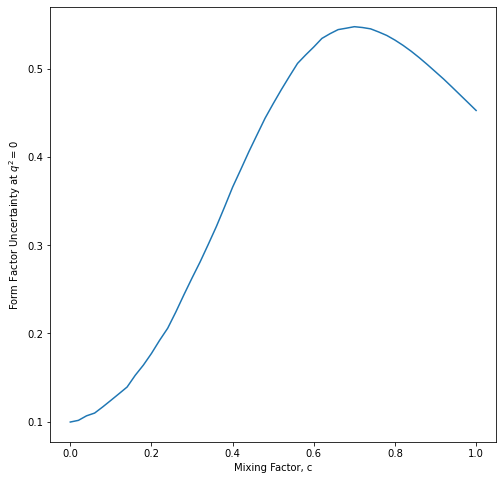

In [74]:
plt.rcParams["figure.figsize"] = (8,8)
plt.plot(c_space,results)
plt.ylabel(r"Form Factor Uncertainty at $q^2=0$")
plt.xlabel("Mixing Factor, c")
plt.show()

In [68]:
results = []
c_space = np.linspace(0,0.01,51)
for c in tqdm(c_space):
    results.append(poolfunction(c))

100%|██████████| 51/51 [03:43<00:00,  4.38s/it]


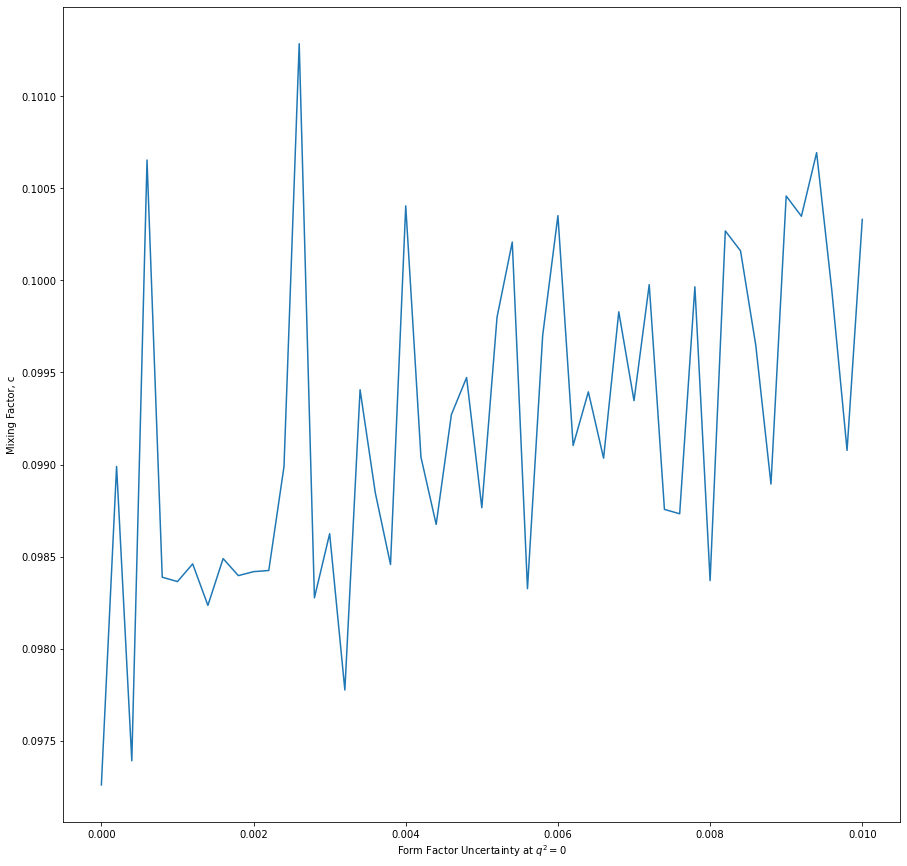

In [69]:
plt.rcParams["figure.figsize"] = (15,15)
plt.plot(c_space,results)
plt.xlabel(r"Form Factor Uncertainty at $q^2=0$")
plt.ylabel("Mixing Factor, c")
plt.show()

In [ ]:
# c_space = np.linspace(0,1,21)
# p = Pool(os.cpu_count())
# results = p.map(poolfunction,c_space)
# p.close()
# results = np.array(results)
# print(results)

In [33]:
zero_bounds_from_input_q2([17,23.728],[17,18,23.728],nboot=1000,c = 1)[2]

<ipython-input-30-b75c578c6b8f>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ffs = np.array(ffs_raw)#[0]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [198]:
nboot = 500
ffin = np.array(ffs_from_input_q2([17,23.728],[17,18,23.728],nboot),dtype = object)

fpaverages = np.zeros((nboot,2))
fzaverages = np.zeros((nboot,3))
print(np.shape(ffin[:,1]),ffin[:,1][3][1][2])#[:][1][:]
for i in range(nboot):
    fpaverages[i,0] = ffin[:,0][i][1][0]
    fpaverages[i,1] = ffin[:,0][i][1][1]
    fzaverages[i,0] = ffin[:,1][i][1][0]
    fzaverages[i,1] = ffin[:,1][i][1][1]
    fzaverages[i,2] = ffin[:,1][i][1][2]
meanfps = np.mean(fpaverages,axis=0)
meanfzs = np.mean(fzaverages,axis=0)
print(meanfzs,meanfps)
#kin_bounds(ffin[0],ffin[1])

(500, 2)
(500,) 0.8825280835292049
[0.46880406 0.51279985 0.87473864] [0.91849937 3.15393966]


In [118]:
bounds_from_input_q2([17, 19],[17, 18, 19],200,np.array([0,3,6,9,12]))

TypeError: Gmatrix() missing 1 required positional argument: 'tpinlist'

In [12]:
inputvardata = []
lowervals = np.linspace(17,20,16)
nboot=2000
for lower in tqdm(lowervals):
    inputvardata.append(bounds_from_input_q2([lower,23.72835562],[lower,0.5*(lower+23.72835562),23.72835562],nboot,np.array([0,3,6,9,12])))

inputvardata = np.array(inputvardata)
resultstlist = inputvardata[0,:,0]

a = np.zeros((len(resultstlist),np.shape(lowervals)[0],2))
b = np.zeros((len(resultstlist),np.shape(lowervals)[0],2))
emptyarray = []
boundsresults = []
#print(inputvardata)
for lower in range(np.shape(lowervals)[0]):
    for t in range(len(resultstlist)):
        a[t,lower] = inputvardata[lower,t,[1,3]]
        b[t,lower] = inputvardata[lower,t,[2,4]]
boundsresults = [a,b]
boundsresults = np.array(boundsresults)
zerobounds = boundsresults[0][0]

100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


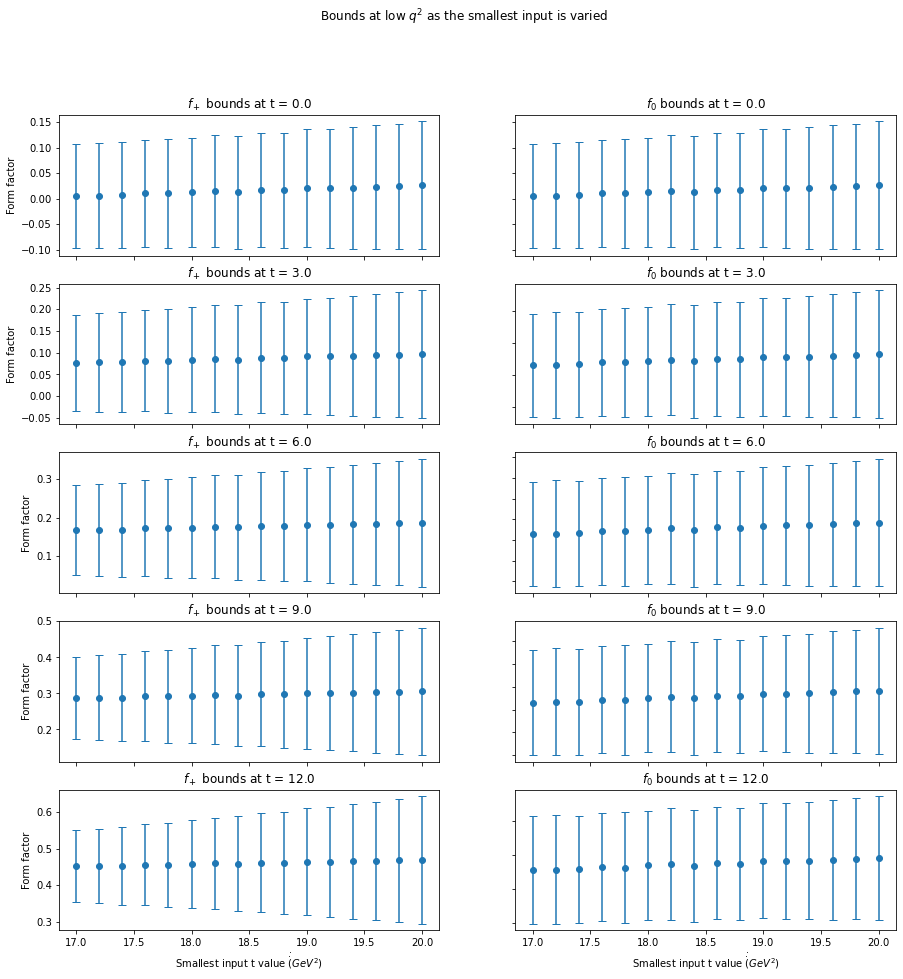

In [13]:
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(np.shape(boundsresults)[1], np.shape(boundsresults)[0],sharex=True, sharey=False)
fig.suptitle(r'Bounds at low $q^2$ as the smallest input is varied')
#colours = [str(val/np.shape(boundsresults)[2]) for val in range(np.shape(boundsresults)[2])]
for t in range(np.shape(boundsresults)[1]):
    #labelval = lowervals[t]
    for ff in range(np.shape(boundsresults)[0]):
        axs[t,ff].errorbar(lowervals[:], boundsresults[ff,t,:,0], yerr=boundsresults[ff,t,:,1], xerr=None, fmt='o',capsize=4)#,color=colours[t]label = r"{}".format(labelval)
        axs[t,ff].set_title(r"$f_{}$ bounds at t = {}".format(("+" if ff == 0 else "0"),resultstlist[t]))
        
for ax in axs.flat:
    ax.set(xlabel=r"Smallest input t value $\.\. (GeV^2)$", ylabel=r"Form factor")
        
for ax in axs.flat:
    ax.label_outer()
#plt.savefig("fferroroverrange_vs_smallestt.pdf", bbox_inches="tight")
plt.show()

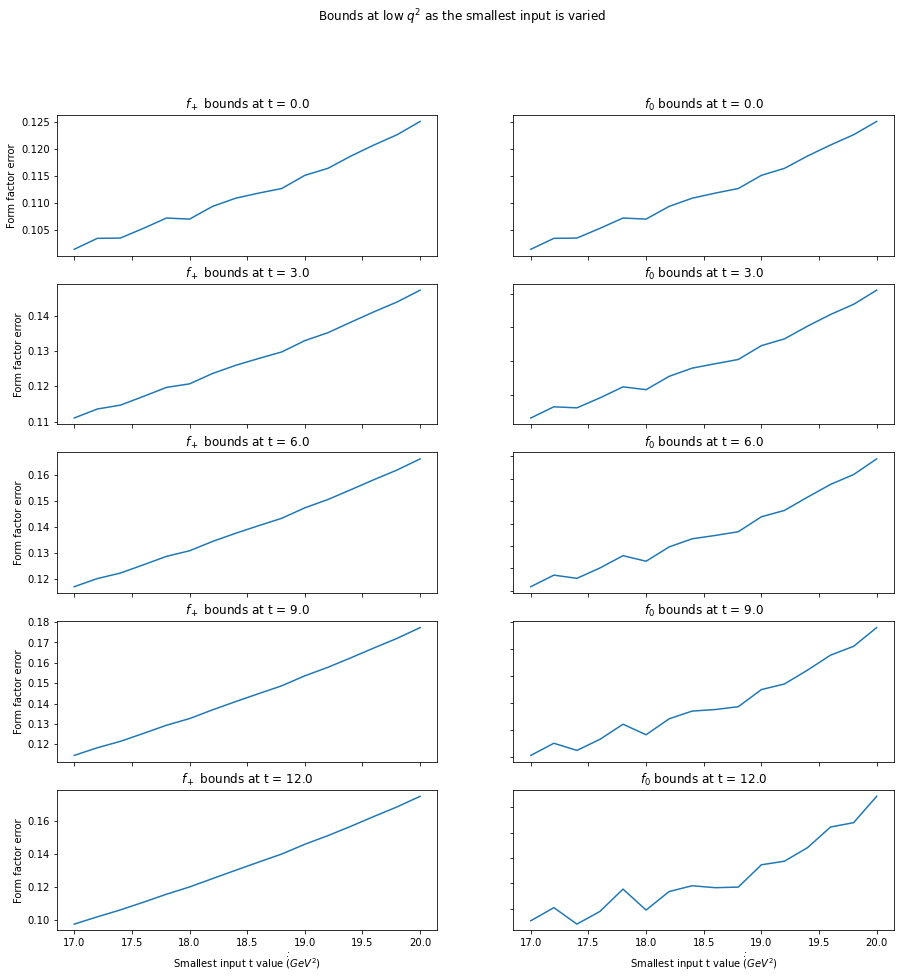

In [14]:
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(np.shape(boundsresults)[1], np.shape(boundsresults)[0],sharex=True, sharey=False)
fig.suptitle(r'Bounds at low $q^2$ as the smallest input is varied')
#colours = [str(val/np.shape(boundsresults)[2]) for val in range(np.shape(boundsresults)[2])]
for t in range(np.shape(boundsresults)[1]):
    #labelval = lowervals[t]
    for ff in range(np.shape(boundsresults)[0]):
        axs[t,ff].plot(lowervals[:], boundsresults[ff,t,:,1])
        axs[t,ff].set_title(r"$f_{}$ bounds at t = {}".format(("+" if ff == 0 else "0"),resultstlist[t]))
        
for ax in axs.flat:
    ax.set(xlabel=r"Smallest input t value $\.\. (GeV^2)$", ylabel=r"Form factor error")
        
for ax in axs.flat:
    ax.label_outer()
#plt.savefig("fferroroverrange_vs_smallestt.pdf", bbox_inches="tight")
plt.show()

In [15]:
inputvardata = []
lower = 17
midvals = np.linspace(17.1,19.9,15)
nboot=2000
for middle in tqdm(midvals):
    inputvardata.append(bounds_from_input_q2([lower,23.72835562],[lower,middle,23.72835562],nboot,np.array([0,3,6,9,12])))

inputvardata = np.array(inputvardata)
resultstlist = inputvardata[0,:,0]

a = np.zeros((len(resultstlist),np.shape(midvals)[0],2))
b = np.zeros((len(resultstlist),np.shape(midvals)[0],2))
emptyarray = []
boundsresults = []
#print(inputvardata)
for middle in range(np.shape(midvals)[0]):
    for t in range(len(resultstlist)):
        a[t,middle] = inputvardata[middle,t,[1,3]]
        b[t,middle] = inputvardata[middle,t,[2,4]]
boundsresults = [a,b]
boundsresults = np.array(boundsresults)
zerobounds = boundsresults[0][0]

100%|██████████| 15/15 [00:43<00:00,  2.91s/it]


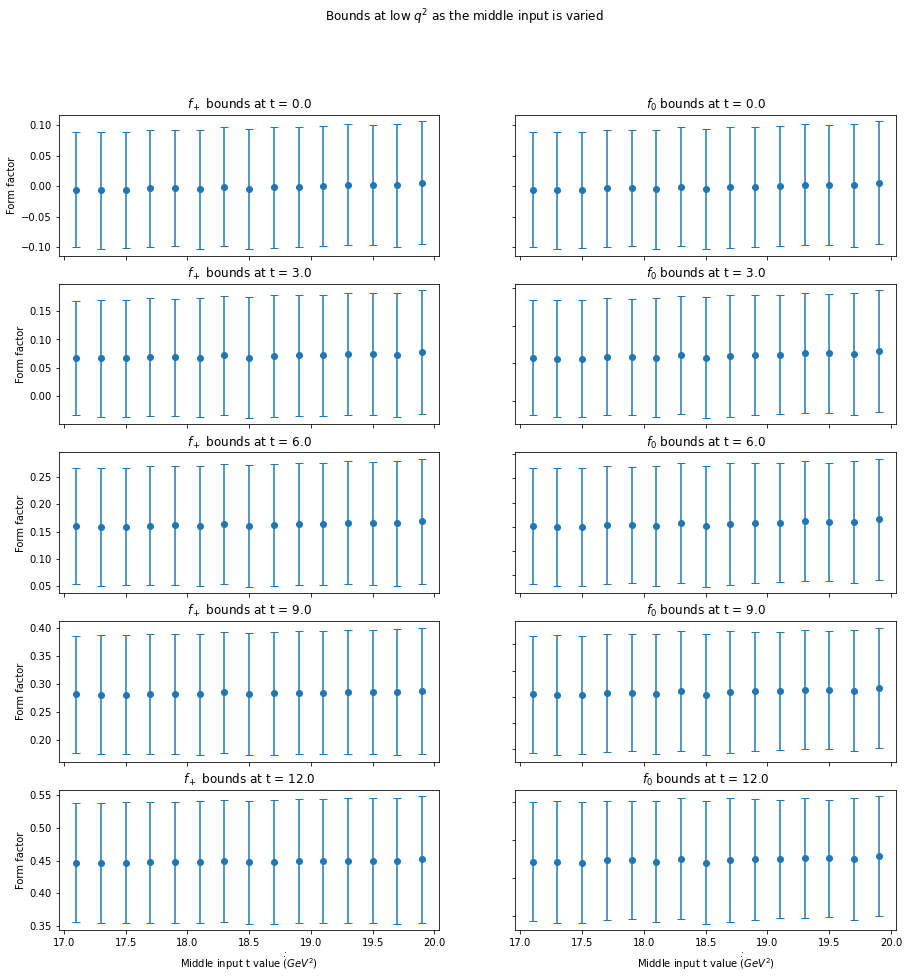

In [16]:
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(np.shape(boundsresults)[1], np.shape(boundsresults)[0],sharex=True, sharey=False)
fig.suptitle(r'Bounds at low $q^2$ as the middle input is varied')
#colours = [str(val/np.shape(boundsresults)[2]) for val in range(np.shape(boundsresults)[2])]
for t in range(np.shape(boundsresults)[1]):
    #labelval = lowervals[t]
    for ff in range(np.shape(boundsresults)[0]):
        axs[t,ff].errorbar(midvals[:], boundsresults[ff,t,:,0], yerr=boundsresults[ff,t,:,1], xerr=None, fmt='o',capsize=4)#,color=colours[t]label = r"{}".format(labelval)
        axs[t,ff].set_title(r"$f_{}$ bounds at t = {}".format(("+" if ff == 0 else "0"),resultstlist[t]))
        
for ax in axs.flat:
    ax.set(xlabel=r"Middle input t value $\.\. (GeV^2)$", ylabel=r"Form factor")
        
for ax in axs.flat:
    ax.label_outer()
#plt.savefig("fferroroverrange_vs_smallestt.pdf", bbox_inches="tight")
plt.show()

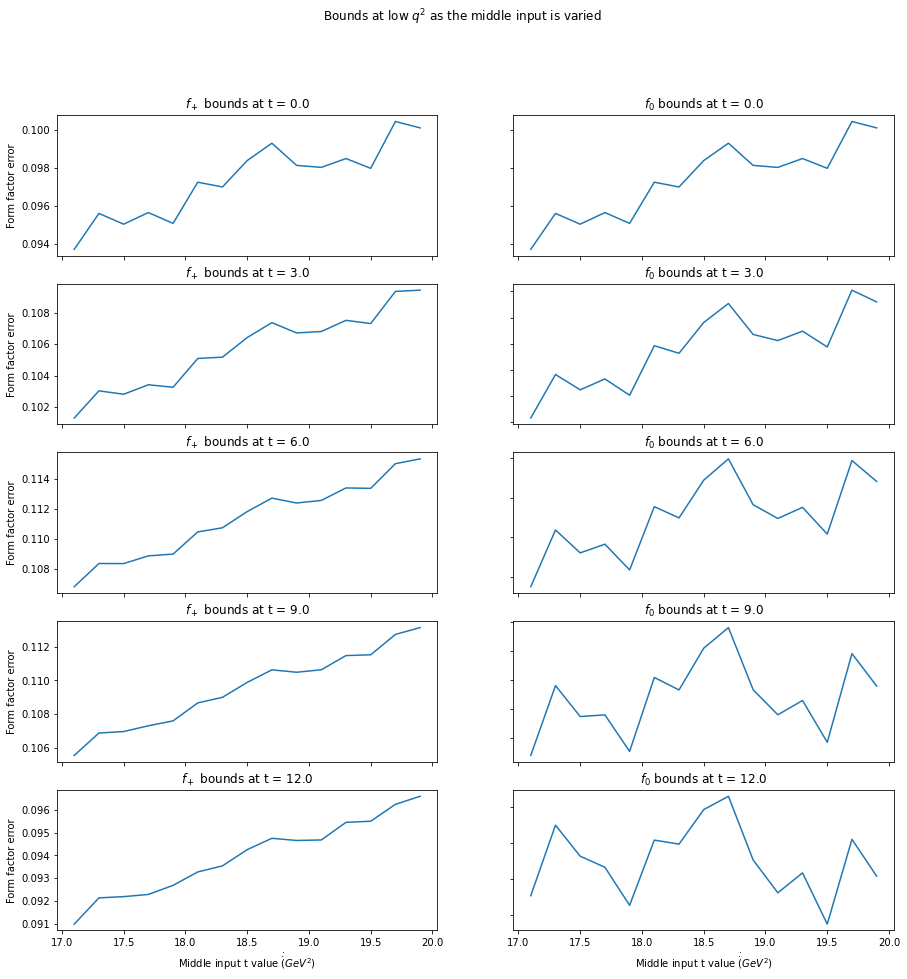

In [17]:
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(np.shape(boundsresults)[1], np.shape(boundsresults)[0],sharex=True, sharey=False)
fig.suptitle(r'Bounds at low $q^2$ as the middle input is varied')
#colours = [str(val/np.shape(boundsresults)[2]) for val in range(np.shape(boundsresults)[2])]
for t in range(np.shape(boundsresults)[1]):
    #labelval = lowervals[t]
    for ff in range(np.shape(boundsresults)[0]):
        axs[t,ff].plot(midvals[:], boundsresults[ff,t,:,1])
        axs[t,ff].set_title(r"$f_{}$ bounds at t = {}".format(("+" if ff == 0 else "0"),resultstlist[t]))
        
for ax in axs.flat:
    ax.set(xlabel=r"Middle input t value $\.\. (GeV^2)$", ylabel=r"Form factor error")
        
for ax in axs.flat:
    ax.label_outer()
#plt.savefig("fferroroverrange_vs_smallestt.pdf", bbox_inches="tight")
plt.show()